# Installing and importing packages

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
from jax.scipy.special import erf
import jax.random as random
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import jax
import numpy as np
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 3.5 MB/s eta 0:00:00


# Domaine adaptation for 2D points cloud

In this section, we create 2 sets of points clouds : 
* in the first set (source set) there is `n1` points labeled 1 and `n2` labeled -1, **the labels are known** during training.
* in the second set (target set) there is `n1_` points labeled 1 and `n2_` labeled -1, **the labels are not known** during training.

The main idea is to create a classifier (here an SVM) for the first set and using optimal transport, to adapt it for the second dataset.

## Datasets generation and first classifier

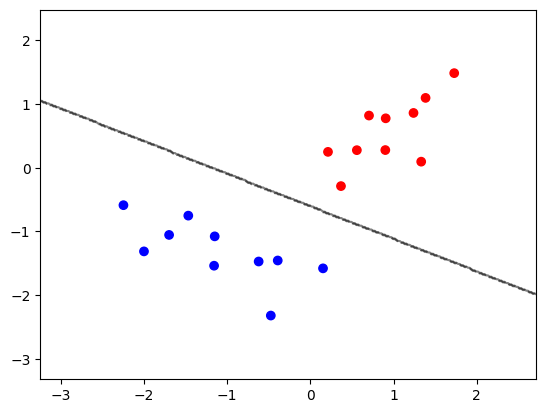

In [33]:
# Generate random points following the Gaussian distributions for the source
mean1 = jnp.array([1, 1])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([-1, -1])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1 = 10
n2 =10

def Generate2DDataset(mean1, cov1, mean2, cov2,n1 = 10,  n2 = 10, randomkey =1):
  """
    Generate random a set of random points following the Gaussian distribution : 
    `n1` points wil be labeled 1 and be distributed w.r.t. a Gaussian law (`mean1`, `cov1`)
    `n2` points wil be labeled -1 and be distributed w.r.t. a Gaussian law (`mean2`, `cov2`)
    """
  key = random.PRNGKey(randomkey)
  x1 = random.multivariate_normal(key, mean1, cov1, (n1,))
  x2 = random.multivariate_normal(key, mean2, cov2, (n2,))
  X = jnp.concatenate([x1, x2])
  y = jnp.concatenate([jnp.ones((n1,)), -jnp.ones((n2,))])
  return x1,x2,X,y

x1,x2,X,y = Generate2DDataset(mean1, cov1, mean2, cov2,n1, n2)


def makeSVM(X,y, kernel = 'linear') :
  "Create a SVM classifier with kernel `kernel` from a dataset of features `X` and labels `y`"
  svm = SVC(kernel=kernel)
  svm.fit(X, y)
  return svm

svm = makeSVM(X,y)

# Plot the data and the decision boundary
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.show()

In [35]:
# Generate random points following the Gaussian distributions for target 
mean1 = jnp.array([3, 1])
cov1 = jnp.array([[0.4, 0.1], [0.3, 0.5]])
mean2 = jnp.array([3, -2])
cov2 = jnp.array([[0.3, -0.4], [-0.2, 0.4]])
n1_=10
n2_=10
x1_,x2_,X_,y_ = Generate2DDataset(mean1, cov1, mean2, cov2, n1_, n2_, randomkey =2)

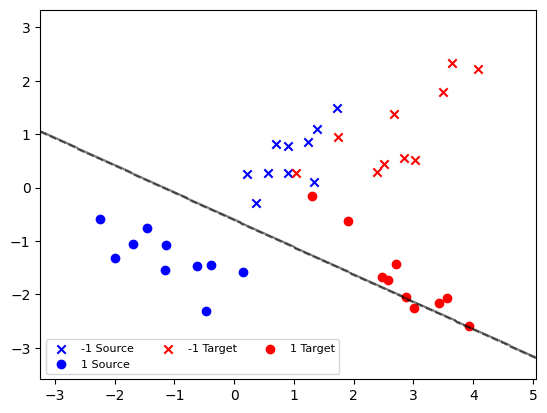

In [36]:
# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The reuslting classifier is not all adapted for the target datset

## Optimal Transport from source to target dataset

In [24]:
# Plotting the transportation plan
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)

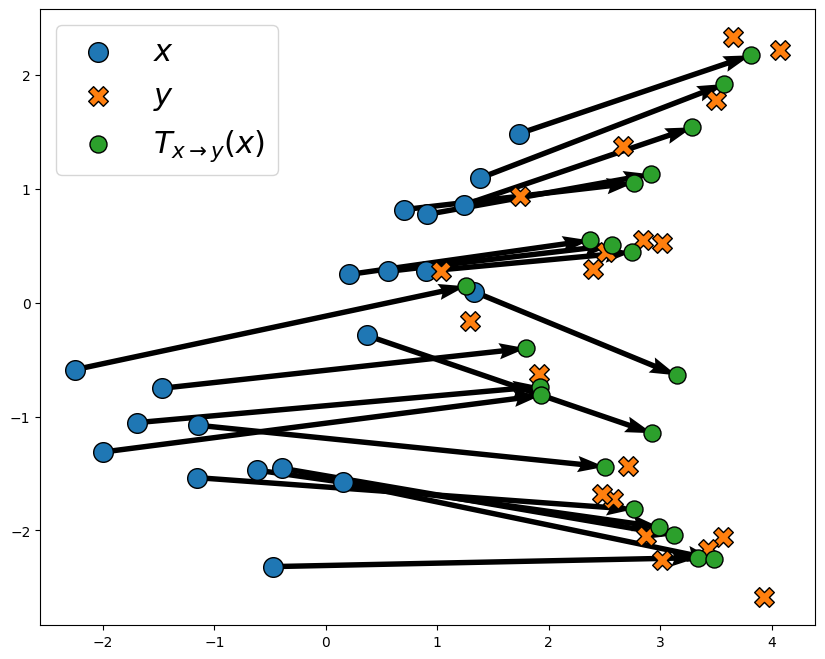

In [37]:
def getTransport(X, X_, cost_fn = costs.SqEuclidean(), plot = True):
  """ Get the transported points from a source set `X` to a target set `X_, where the cost function is defined by `cost_fn`. `plot` = `True` plot the transportation plan if possible. """
  geom = pointcloud.PointCloud(X, X_, cost_fn=cost_fn) #  cost_fn permet de changer la fonction coût ici
  out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
  dual_potentials = out.to_dual_potentials()
  if plot == True and len(X[0])==2 and len(X_[0]) == 2:
    plot_map(X, X_, dual_potentials.transport(X))
   
  return dual_potentials.transport(X)

tX = getTransport(X,X_)

We now train the classifier on the transported points `tX` using the source labeled `y`

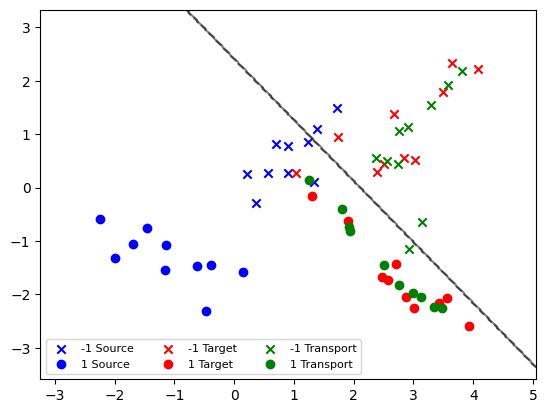

In [44]:
svm = makeSVM(tX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(tX[:,0][:n1], tX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(tX[:,0][n1:], tX[:,1][n1:], marker='o', color=colors[2])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport', '1 Transport'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

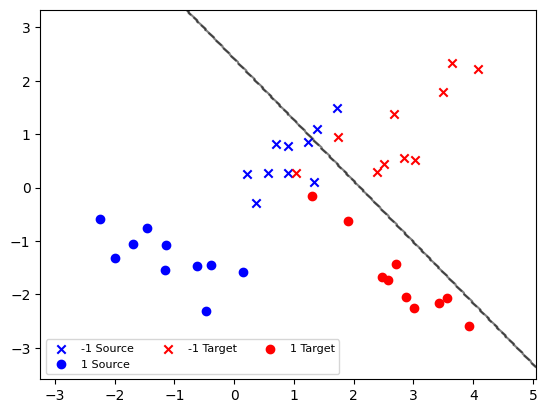

In [45]:
# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

This new classifier is way more adapted for the target dataset.

## Trying to get best of both worlds

Each of the classifer is well adapted for the source or the target dataset only. Since the source and target dataset "live" on the same space (here $\mathbb{R}^2$), we're looking for a classifier that seperate fairly all the points (from both the source and the target datasets) laeled -1 and 1

### First idea : mid transported points

We simply take the middle of the if the transportation plan and build the classifier on those points.

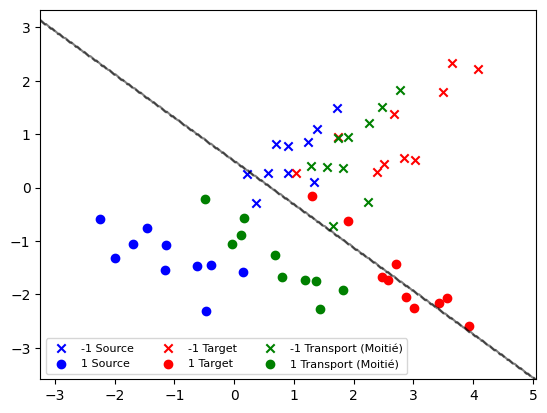

In [46]:
# We plot the boundary decision made for the middle of the transportation plan :
meanX = (tX+X)/2
svm = makeSVM(meanX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(meanX[:,0][:n1], meanX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(meanX[:,0][n1:], meanX[:,1][n1:], marker='o', color=colors[2])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport (Moitié)', '1 Transport (Moitié)'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

## Second idea : Voting Classifier

We cut out the transport plan into`step` steps, build a classifier for each intermediary step (including the first classifier on the source dataset) and build a voting classifier that be train either on all the intermediary step of the transportation plan or only on the source and final transported points. 

In [47]:
from sklearn.ensemble import VotingClassifier
step = 10

def votingclassifier(X,y, tX,step = 10, longtrain = True):
  """ Build a Voting classifer. The intermediary classifier are trained on each step of the transportation plan
   from the source dataset `X` to the transported dataset `tX` with label `y`, that has been cut out in `step`steps.
   The argument `longtrain` = `True`, `False`or `'both'` defines how the resulting voting classifier(s) is (are) trained : 
   * `True` : on all intermediary dataset
   * `False` :  only on original and transported  dataset
   * `both` : the two previous classifiers are returned"""
  svm0 = makeSVM(X,y)
  X_t = X
  y_t = y
  if longtrain ==False or longtrain =='both':
    X_t2 = jnp.concatenate([X, tX])
    y_t2 = jnp.concatenate([y, y])
  svm = [svm0]
  for i in range(1, step+1):
    newX = ((step-i)/step)*X + (i/step)*tX
    X_t = jnp.concatenate([X_t, newX])
    y_t = jnp.concatenate([y_t, y])
    svm.append(makeSVM(newX,y))

  estimator = []
  for i in range(len(svm)):
    estimator.append((str(i), svm[i]))
  # Create voting ensemble of SVM linear classifiers
  ensemble = VotingClassifier(estimators=estimator, voting='hard')

  # Fit the ensemble on the training data
  if longtrain == False :
    ensemble.fit(X_t2, y_t2)
    return ensemble
  elif longtrain == 'both':
    return ensemble.fit(X_t,y_t), ensemble.fit(X_t2,y_t2)
  else : 
    return ensemble.fit(X_t,y_t)

ensemble1, ensemble2 = votingclassifier(X,y,tX, step, longtrain = 'both')

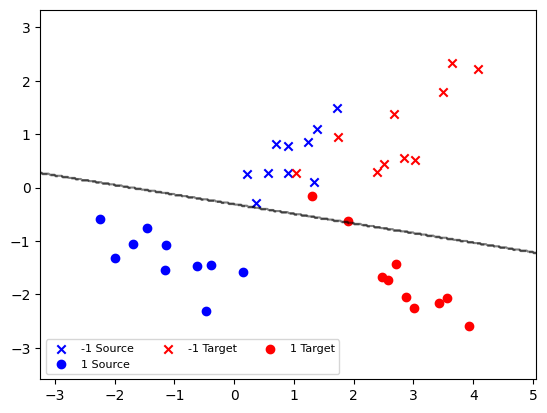

In [48]:
# Plot with the training on all the intermediary steps of the transport plan

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])


x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

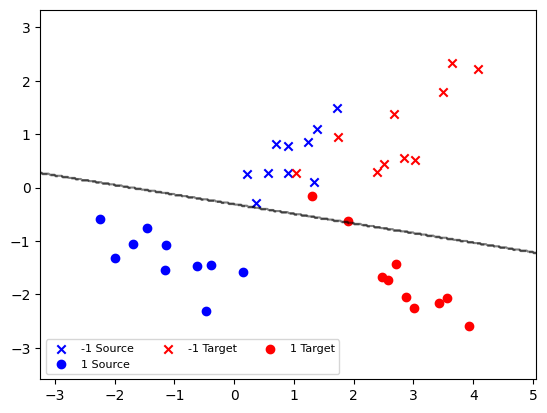

In [49]:
# Plot with the training on the orignal and the transported points

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The difference is minimal because the dataset are sufficiently separated.

# Sattelite images temporal domain adaptation

Install the requirement to deal with sattelite images from https://nassgeodata.gmu.edu/CropScape/ (U.S.):

In [ ]:
!apt install libpq-dev
!apt install gdal-bin
!apt install libgdal-dev

Execute the above, and only then continue with the following:

In [ ]:
!apt list --installed | grep "gdal"
!gdalinfo --version

Install the printed version above, for us it was:

In [ ]:
!pip install gdal==3.2.2

Check:

In [2]:
!gdalinfo --version

GDAL 3.2.2, released 2021/03/05


In [32]:
import numpy as np
from osgeo import gdal, gdal_array
import pandas as pd
import operator
import gc
import os
import os.path as osp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

2023-04-16 11:40:04.349266: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 11:40:04.557158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 11:40:04.557746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 11:40:06.202461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [48]:
path = './data/crop/images/'
img_2017 = '2017.tif'

In [49]:
roi_ds = gdal.Open(osp.join(path, img_2017), gdal.GA_ReadOnly)

In [50]:
roi = roi_ds.GetRasterBand(1).ReadAsArray()

How many pixels are in each class?

In [51]:
classes = np.unique(roi)
classes

array([  0,   1,   2,   4,   5,   6,  10,  21,  24,  26,  27,  28,  29,
        31,  36,  37,  42,  43,  44,  50,  53,  58,  59,  61,  74, 111,
       121, 122, 123, 124, 131, 141, 142, 143, 152, 176, 190, 195, 205,
       216, 225, 226, 236, 238], dtype=uint8)

In [52]:
dict = {}
for c in classes:
    dict[c] = (roi == c).sum()
sorted_x = sorted(dict.items(), key=operator.itemgetter(1))
print("Top 5 classes and pixel counts \n",sorted_x[-5:])

Top 5 classes and pixel counts 
 [(4, 1412227), (152, 2942111), (24, 3517032), (176, 6620948), (2, 7390874)]


In [53]:
imgs = ['2017.tif', '2022.tif']
images = [osp.join(path, img) for img in imgs]

In [54]:
top_classes = list(map(lambda z: z[0], sorted_x[-5:]))
top_classes

[4, 152, 24, 176, 2]

In [55]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#X = img_b1[roi > 0, :]  
y = roi[roi > 0]

We have 26316960 samples
The training data include 43 classes: [  1   2   4   5   6  10  21  24  26  27  28  29  31  36  37  42  43  44
  50  53  58  59  61  74 111 121 122 123 124 131 141 142 143 152 176 190
 195 205 216 225 226 236 238]


In [129]:
#69,75,36,121,225
print("Reading class 69")
df = pd.DataFrame()

for c in top_classes:
    
    temp = pd.DataFrame()
    
    print(c)
    
    for img in images:

        #TODO: introduce a change of domain for a scpeficic year here

        print(img)

        train_ds = gdal.Open(img, gdal.GA_ReadOnly)

        print(train_ds.RasterXSize,train_ds.RasterYSize)

        img_b1 = np.zeros((train_ds.RasterYSize, train_ds.RasterXSize, train_ds.RasterCount),
                       gdal_array.GDALTypeCodeToNumericTypeCode(train_ds.GetRasterBand(1).DataType))
        
        for b in range(img_b1.shape[2]):
            img_b1[:, :, b] = train_ds.GetRasterBand(b + 1).ReadAsArray()
        
        print(img_b1.shape)


        Xt = img_b1[roi==c, :] 
        
        Xt1 = pd.DataFrame(Xt)
        
        Xt2 = Xt1.sample(n=100000)
        
        Xt2.reset_index(drop=True,inplace=True)
        
        temp = pd.concat([Xt2,temp],axis=1)
        
        temp["class"] = c
        #temp.reset_index(drop=True,inplace=True)
      
    df = pd.concat([temp,df],axis=0)
    df.reset_index(drop=True,inplace=True)
    
    gc.collect()

Reading class 69
4
./data/crop/images/2017.tif
6541 4025
(4025, 6541, 1)
./data/crop/images/2022.tif
6541 4025
(4025, 6541, 1)
152
./data/crop/images/2017.tif
6541 4025
(4025, 6541, 1)
./data/crop/images/2022.tif
6541 4025
(4025, 6541, 1)
24
./data/crop/images/2017.tif
6541 4025
(4025, 6541, 1)
./data/crop/images/2022.tif
6541 4025
(4025, 6541, 1)
176
./data/crop/images/2017.tif
6541 4025
(4025, 6541, 1)
./data/crop/images/2022.tif
6541 4025
(4025, 6541, 1)
2
./data/crop/images/2017.tif
6541 4025
(4025, 6541, 1)
./data/crop/images/2022.tif
6541 4025
(4025, 6541, 1)


In [130]:
df

,0,0,class
0,2,2,2
1,2,2,2
2,2,2,2
3,2,2,2
4,2,2,2
...,...,...,...
499995,24,4,4
499996,2,4,4
499997,2,4,4
499998,2,4,4


## Plot of some images from 2017 (domain 1)

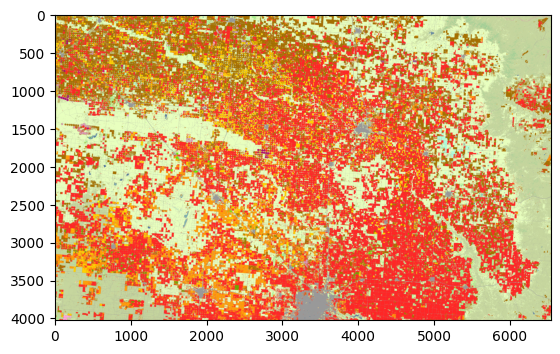

In [151]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img=mpimg.imread(images[0])
imgplot = plt.imshow(img)

## Plot of some images from 2022 (domain 2)

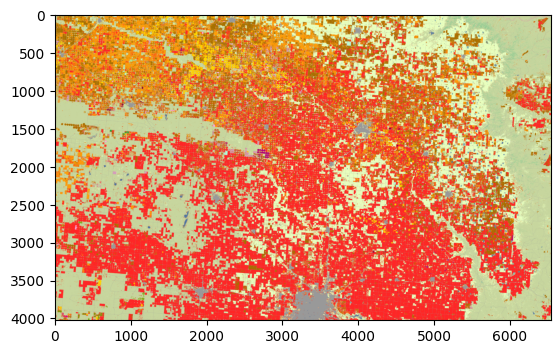

In [152]:
img=mpimg.imread(images[1])
imgplot = plt.imshow(img)

In [153]:
img.shape

(4025, 6541, 4)

## Model

In [131]:
labels = df.iloc[:,-1]

In [133]:
data = df.drop(df.columns[-1],axis=1)
data.shape

(500000, 2)

In [146]:
input_size = data.shape[-1]

In [134]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = tf.keras.utils.to_categorical(encoded_Y,num_classes=5) 

In [135]:
# split
X_train, X_test, y_train, y_test = train_test_split(data, dummy_y, test_size=0.05, random_state=42,shuffle = True)

In [136]:
# scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [138]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

In [141]:
import tensorflow.keras.layers as layers
import tensorflow as tf

In [147]:
model = tf.keras.Sequential()
model.add(layers.Dense(200, input_shape=(input_size, ), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5),kernel_initializer=tf.keras.initializers.glorot_normal(seed=seed),bias_initializer='zeros'))
model.add(layers.Dropout(.4)) #TODO change
model.add(layers.Dense(5, activation='softmax'))
model.summary()

# Compile model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               600       
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 1,605
Trainable params: 1,605
Non-trainable params: 0
_________________________________________________________________


In [148]:
sgd = tf.keras.optimizers.Adadelta()
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [149]:
model.fit(X_train, y_train,
          epochs=2,
          batch_size=100,
         shuffle=True)

Epoch 1/2
4750/4750 [==============================] - 19s 4ms/step - loss: 1.5169 - acc: 0.3547
Epoch 2/2
4750/4750 [==============================] - 18s 4ms/step - loss: 1.3567 - acc: 0.3989


In [150]:
score = model.evaluate(X_test, y_test, batch_size=100)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


250/250 [==============================] - 1s 2ms/step - loss: 1.2829 - acc: 0.4026

acc: 40.26%


# Caltech Office Dataset

The dataset contains images coming from four different domains: Amazon (online merchant), the Caltech-256 image collection, Webcam (images taken from a webcam) and DSLR (images taken from a high resolution digital SLR camera). The variability of the different domains come from several factors: presence/absence of background, lightning conditions, noise, etc. We consider the features set DeCaf: these features are extracted as the sparse activation of
the neurons from the fully connected 6th and 7th layers of a convolutional network trained on imageNet and then fine tuned on the visual recognition tasks considered here. As such, they form vectors with 4096 dimensions.

## Get the dataset

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
download_and_unzip('https://github.com/mdlbm/Optimal-Transport-Domain-Adaptation/raw/main/data/decaf6.zip')


In [ ]:
import os, sys, traceback
import matplotlib.pylab as pylab
import numpy as np
import pylab as pl
from scipy.io import loadmat
from scipy.stats.mstats import zscore
# Four domains: { Caltech10, amazon, webcam, dslr }
possible_DTS = ['caltech', 'amazon', 'webcam', 'dslr']

tests = []
data = {}

for ds in possible_DTS:
    if "google.colab" in sys.modules:
      path = '/content/'+ds+'_decaf.mat'
    else :
      path = ds+'_decaf.mat'
    possible_data = loadmat(path)
    feat = possible_data['feas'].astype(float)
    labels = possible_data['labels']
    data[ds]=[feat,labels]


##Create a simple MLP for one of the dataset

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['caltech'][0], data['caltech'][1], test_size=0.1, random_state=42)

# Define the neural network model
model = MLPClassifier(hidden_layer_sizes=(8192,), max_iter=500, alpha=0.01,
                      solver='sgd', verbose=10, random_state=42,
                      learning_rate_init=0.1)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 23.02449881
Iteration 2, loss = 1361.20078627
Iteration 3, loss = 877460.17365629
Iteration 4, loss = 18149310.25270613
Iteration 5, loss = 62412126.64571945
Iteration 6, loss = 99227653.34415349
Iteration 7, loss = 122466566.54041953
Iteration 8, loss = 135728095.45843756
Iteration 9, loss = 142906006.46134025
Iteration 10, loss = 146630230.30781305
Iteration 11, loss = 148457010.53613898
Iteration 12, loss = 149258235.63113102
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.48672566371681414


## Create MLP classifier by using transportation plans

In [ ]:
# Transport one dataset to another :

def DataTransport(dataset1, dataset2, hidden_size = 4096):
  trX = getTransport(data[dataset1][0], data[dataset2][0])
  # Define the neural network model
  model = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=500, alpha=0.01,
                        solver='sgd', verbose=10, random_state=42,
                        learning_rate_init=0.1)

  # Train the model
  model.fit(trX, data[dataset1][1])

  # Evaluate the model on the test set
  accuracy = model.score(data[dataset2][0], data[dataset2][1])
  print("Accuracy:", accuracy)
  return model

In [ ]:
for i in possible_DTS:
  for j in possible_DTS:
    if i != j: 
      print('Accuracy result from {} to {} :'.format(i,j))
      DataTransport(i,j)

      

Accuracy result from caltech to amazon :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 46.80579969
Iteration 2, loss = 37992.92704519
Iteration 3, loss = 34768615.91888478
Iteration 4, loss = 249029472.39372209
Iteration 5, loss = 474113429.67585689
Iteration 6, loss = 625506465.29343486
Iteration 7, loss = 714757164.25311518
Iteration 8, loss = 764489594.88840258
Iteration 9, loss = 791386124.76830924
Iteration 10, loss = 805628410.55258715
Iteration 11, loss = 812999548.47691596
Iteration 12, loss = 816677797.60540688
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.19728601252609604
Accuracy result from caltech to webcam :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 23.89081895
Iteration 2, loss = 21282.67407314
Iteration 3, loss = 112379.20987495
Iteration 4, loss = 203920.05515054
Iteration 5, loss = 266836.49088608
Iteration 6, loss = 304238.98283623
Iteration 7, loss = 325163.04837861
Iteration 8, loss = 336500.13152622
Iteration 9, loss = 342508.56491857
Iteration 10, loss = 345619.28189555
Iteration 11, loss = 347171.02945914
Iteration 12, loss = 347889.70850045
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.17627118644067796
Accuracy result from caltech to dslr :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 18.97704509
Iteration 2, loss = 6776.22227800
Iteration 3, loss = 99428.75095414
Iteration 4, loss = 348089.74759176
Iteration 5, loss = 589936.58510166
Iteration 6, loss = 750196.73173905
Iteration 7, loss = 844117.67199277
Iteration 8, loss = 896290.81671003
Iteration 9, loss = 924441.05646896
Iteration 10, loss = 939308.24941632
Iteration 11, loss = 946970.05675142
Iteration 12, loss = 950761.20813194
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.08917197452229299
Accuracy result from amazon to caltech :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 15.94424816
Iteration 2, loss = 987.18581433
Iteration 3, loss = 32285.04958247
Iteration 4, loss = 90082.92856090
Iteration 5, loss = 139740.45582294
Iteration 6, loss = 174457.31988482
Iteration 7, loss = 196801.18061598
Iteration 8, loss = 210609.07291456
Iteration 9, loss = 218943.44792959
Iteration 10, loss = 223895.30159649
Iteration 11, loss = 226797.69107536
Iteration 12, loss = 228471.50443377
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.3098842386464826
Accuracy result from amazon to webcam :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 14.20050589
Iteration 2, loss = 97.82866064
Iteration 3, loss = 1407.38764280
Iteration 4, loss = 4480.66145770
Iteration 5, loss = 8539.95341497
Iteration 6, loss = 11964.26581682
Iteration 7, loss = 14344.17057125
Iteration 8, loss = 15871.50059784
Iteration 9, loss = 16813.51956010
Iteration 10, loss = 17381.18330888
Iteration 11, loss = 17717.77713097
Iteration 12, loss = 17914.47141426
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.20677966101694914
Accuracy result from amazon to dslr :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 12.99671683
Iteration 2, loss = 1272.88480829
Iteration 3, loss = 131425.22188852
Iteration 4, loss = 496114.44079345
Iteration 5, loss = 839684.39056415
Iteration 6, loss = 1087907.72577820
Iteration 7, loss = 1250090.61934388
Iteration 8, loss = 1351088.63093484
Iteration 9, loss = 1412342.72473520
Iteration 10, loss = 1448863.21933186
Iteration 11, loss = 1470339.07703635
Iteration 12, loss = 1482780.04872386
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.17834394904458598
Accuracy result from webcam to caltech :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 7.44767124
Iteration 2, loss = 15.83744158
Iteration 3, loss = 36.75965671
Iteration 4, loss = 423.40443455
Iteration 5, loss = 1523.71386331
Iteration 6, loss = 3532.37643826
Iteration 7, loss = 6392.98640236
Iteration 8, loss = 10432.47939680
Iteration 9, loss = 14767.15797420
Iteration 10, loss = 19017.76506205
Iteration 11, loss = 22943.90852782
Iteration 12, loss = 26440.23944945
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.19145146927871773
Accuracy result from webcam to amazon :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 7.97681119
Iteration 2, loss = 18.32876990
Iteration 3, loss = 43.41992886
Iteration 4, loss = 316.18564801
Iteration 5, loss = 9015.97744885
Iteration 6, loss = 26008.84842701
Iteration 7, loss = 98776.45644914
Iteration 8, loss = 203314.52322367
Iteration 9, loss = 320282.47524281
Iteration 10, loss = 436240.16455202
Iteration 11, loss = 544064.37624357
Iteration 12, loss = 640498.92132438
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.1837160751565762
Accuracy result from webcam to dslr :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 8.83544651
Iteration 2, loss = 14.30682781
Iteration 3, loss = 24.98727102
Iteration 4, loss = 886.31743959
Iteration 5, loss = 6597.63931667
Iteration 6, loss = 15838.20163265
Iteration 7, loss = 35790.93436715
Iteration 8, loss = 272718.64533577
Iteration 9, loss = 4910256.25032677
Iteration 10, loss = 15884207.80887714
Iteration 11, loss = 29846572.64259830
Iteration 12, loss = 44657090.81601046
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.3885350318471338
Accuracy result from dslr to caltech :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 5.02535256
Iteration 2, loss = 12.62909840
Iteration 3, loss = 14.51697990
Iteration 4, loss = 25.49787974
Iteration 5, loss = 41.70897644
Iteration 6, loss = 61.33661885
Iteration 7, loss = 84.58215627
Iteration 8, loss = 344.72733815
Iteration 9, loss = 4273.60676658
Iteration 10, loss = 9698.91506083
Iteration 11, loss = 16129.23439354
Iteration 12, loss = 23796.50830924
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.11398040961709706
Accuracy result from dslr to amazon :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 5.61519515
Iteration 2, loss = 13.95249769
Iteration 3, loss = 15.52530479
Iteration 4, loss = 57.13464253
Iteration 5, loss = 112.09316991
Iteration 6, loss = 202.27043106
Iteration 7, loss = 373.99962517
Iteration 8, loss = 3520.32694131
Iteration 9, loss = 35120.06806485
Iteration 10, loss = 225262.93098440
Iteration 11, loss = 436807.80982273
Iteration 12, loss = 685949.90372325
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.32150313152400833
Accuracy result from dslr to webcam :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 7.06456318
Iteration 2, loss = 12.26285519
Iteration 3, loss = 12.32082765
Iteration 4, loss = 17.30385811
Iteration 5, loss = 24.14760282
Iteration 6, loss = 34.04251847
Iteration 7, loss = 45.22190069
Iteration 8, loss = 65.86544468
Iteration 9, loss = 85.81185864
Iteration 10, loss = 123.17206615
Iteration 11, loss = 217.14455221
Iteration 12, loss = 342.65777499
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.44745762711864406


NB : since the different features dataset "lives" on the same space (output of the sparse activation of a neural network) we could make the Voting Classifier). 

